# Part 1: Metropolis-Hastings Algorithm

#### Importing Libraries

We will be importing the following libraries for our exploration into Markov Chain Monte Carlo Algorithms. We will be working with NumPy to help us with mathematical functions and random number generation. Seaborn and Matplotlib gives us the tools for visualising our data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Random number generator

The use setting a `rng` object with a predetermined seed allows for reproducibility of results.

In [2]:
rng = np.random.default_rng(seed=1)

#### Define our target distribution 

The target distribution is defined as having density function of:
$$
f(x) = \frac{1}{2}{\exp(-|x|)}, \textrm{where} \ x \ \epsilon \ \mathbb{R}.
\\ \textrm{(Note: this is Laplace Distribution with parameters } \mu=0, b=1)
$$


In [3]:
def target_dist(x):
    return np.exp(-np.abs(x)) / 2

#### Define random walk Metropolis algorithm
We are tasked with generating $x_0,x_1...,x_N$ values and storing them in a version of the Metropolis-Hastings algorithm consisting of the following steps:

Step 1: Set up initial value $x_0$ as well as a positive integer $N$ and a positive real number $s$.

Step 2: Repeat for $i = 1,...,N$ :
* simulate a random number $x_*$ from the Normal Distribution with mean $x_{i-1}$ and standard deviation $s$.
* compute the ratio: $$r(x_*,x_{i-1}) = \frac{f(x_*)}{f(x_{i-1})}.$$
* generate a random number $u$ from the Uniform Distribution between 0 and 1.
* if $u < r (x_*,x_{i-1})$, set $x_i = x_*$, else set $x_i = x_{i-1}$.

We used the equivalent criterion $\log{u} < \log{r(x_*,x_{i-1})} = \log{f(x_*)} - \log{f(x_{i-1})}$ to avoid numerical errors.


In [4]:
def metro_algo(N, s, initial_value):
    target_samples = []
    x_0 = initial_value
    
    for i in range(N):
        if i >0 : 
            xi_1 = target_samples[i-1]
        else: 
            xi_1 = 0
        # Generate a random number x_star from the Normal distribution
        x_star = rng.normal(loc= xi_1, scale=s)
        # Compute the ratio     
        ratio = target_dist(x_star) / target_dist(xi_1)
        # Generate a random number u from the Uniform distribution
        u = rng.uniform(low=0.0, high=1.0)
        # Check acceptance criterion
        if np.log(u) < np.log(ratio):
            target_samples.append(x_star)
        else: 
            target_samples.append(xi_1)
            
    return target_samples

#parameters 
N = 10000
s = 1
initial_value = 0

#### Part (a): Application of random walk Metropolis Algorithm

We then applied the algorithm using the following parameters $N = 10000$ and $s = 1$. Afterwards we plotted the generated samples $(x_1,...,x_N)$ as a histogram and a kernel density plot in the same figure. We used the `np.linspace` method to overlay a graph of the target distribution $f(x)$ on the figure to visualise the quality of the estimates.

In [5]:
samples = metro_algo(N, s, initial_value)

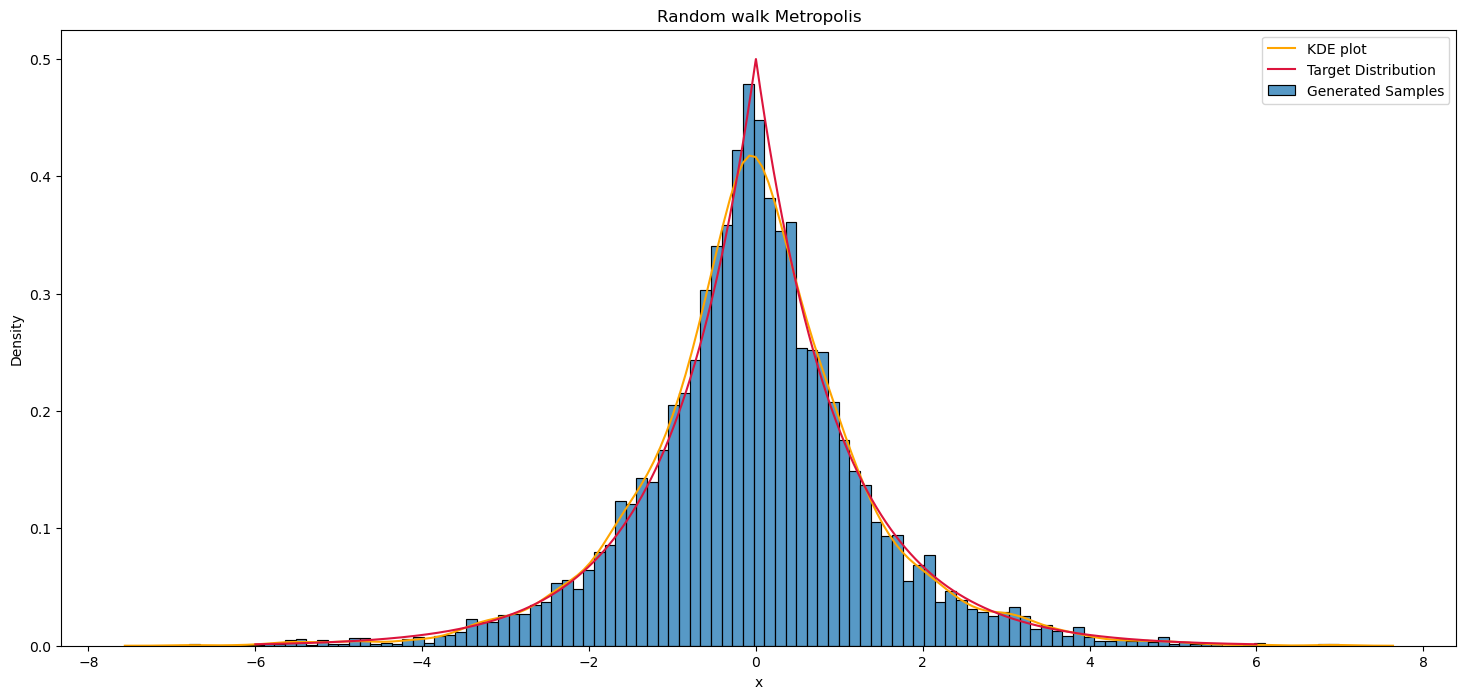

In [6]:
samples = metro_algo(N, s, initial_value)
fig, ax = plt.subplots(1,figsize=(18,8))
sns.histplot(samples, kde=False, stat='density', label='Generated Samples')
sns.kdeplot(samples, color='orange', label='KDE plot')
x_values = np.linspace(-6, 6, num=10000)
plt.plot(x_values, target_dist(x_values), color='crimson', label='Target Distribution')
plt.title('Random walk Metropolis')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

We then calculated the Monte Carlo estimates of the mean and standard deviation. 

In [7]:
mc_mean = np.mean(samples)
mc_std = np.std(samples)

print(f"Monte Carlo estimate of Mean (Sample Mean): {mc_mean:.4f}")
print(f"Monte Carlo estimate of Standard Deviation (Sample Standard Deviation): {mc_std:.4f}")

Monte Carlo estimate of Mean (Sample Mean): -0.0242
Monte Carlo estimate of Standard Deviation (Sample Standard Deviation): 1.3572


#### Part (b): Analysing Convergence using Gelman-Rubin $\hat{R}$ statistic


We assumed that the algorithm would converge in the first part of the question. In order to assess convergence, we obtain a value of the $\hat{R}$ statistic using the following procedure.  

* Generate more than one chain of $x_0,...,x_N$ using different initial values of $x_0$. We then denote each of these chains as $(x_0^{(j)},x_1^{(j)}...,x_N^{(j)})$ for $j = 1,2...,J$.

In [8]:
def metro_chain(N, target_dist, rng, s, initial_value):
    chain = [initial_value]

    for i in range(1, N):
        xi_1 = chain[i - 1]
        x_star = rng.normal(loc=xi_1, scale=s)
        ratio = target_dist(x_star) / target_dist(xi_1)
        u = rng.uniform(low=0.0, high=1.0)

        if np.log(u) < np.log(ratio):
            chain.append(x_star)
        else:
            chain.append(xi_1)

    return chain

# Set parameters
N = 2000  
J = 4 


rng = np.random.default_rng(seed=42)

# Generate J chains with different initial values
initial_values = [0.0, 1.0, -1.0, 2.0]  

chains = [metro_chain(N, target_dist, rng, s=0.001, initial_value=iv) for iv in initial_values]

* We define and compute $M_j$ as the sample mean of chain $j$ as: 
$$ M_j = \frac{1}{N}\sum_{i = 1}^{N}x_i^{(j)}. $$

In [9]:
def compute_sample_mean(chain):
    return np.mean(chain)

sample_means = [compute_sample_mean(chain) for chain in chains]

for j, mean in enumerate(sample_means, start=1):
    print(f'Mean of Chain {j} (M{j}): {mean}')

Mean of Chain 1 (M1): -0.01203603406316083
Mean of Chain 2 (M2): 1.0092443175991905
Mean of Chain 3 (M3): -1.0131103757364164
Mean of Chain 4 (M4): 2.0134451605519565


* We define and compute $V_j$ as the sample variance of chain $j$ as:
$$ V_j = \frac{1}{N}\sum_{i = 1}^{N}(x_i^{(j)} - M_j)^2. $$

In [10]:
def compute_sample_variance(chain, sample_mean):
    N = len(chain)
    return np.sum((chain - sample_mean)**2) / N

sample_variances = [compute_sample_variance(chain, sample_mean) for chain, sample_mean in zip(chains, sample_means)]

for j, variance in enumerate(sample_variances, start=1):
    print(f'Variance of Chain {j} (V{j}): {variance}')

Variance of Chain 1 (V1): 0.0002718672158532986
Variance of Chain 2 (V2): 0.0005492455819366481
Variance of Chain 3 (V3): 0.0002799145673422889
Variance of Chain 4 (V4): 7.846628392415764e-05


* We define and compute overall within sample variance $W$ as:
$$ W = \frac{1}{J}\sum_{j=1}^{J}V_j.$$

In [11]:
overall_within_variance = np.mean(sample_variances)

print(f'Overall Within-Sample Variance (W): {overall_within_variance}')

Overall Within-Sample Variance (W): 0.00029487341226409826


* We define and compute overall sample mean $M$ as:
$$ M = \frac{1}{J}\sum_{j=1}^{J}M_j.$$

In [12]:
overall_sample_mean = np.mean(sample_means)

print(f'Overall Sample Mean (M): {overall_sample_mean}')

Overall Sample Mean (M): 0.4993857670878925


* We define and compute the between sample variance $B$ as: 
$$ B = \frac{1}{J}\sum_{j=1}^{J}(M_j - M)^2.$$

In [14]:
between_sample_variance = np.mean(np.sum((sample_means - overall_sample_mean)**2))

print(f'Between-Sample Variance (B): {between_sample_variance}')

Between-Sample Variance (B): 5.101528429217251


* Finally, we compute the $\hat{R}$ value as:
$$ \hat{R} = \sqrt\frac{B+W}{W} $$

In [15]:
rhat_value = np.sqrt((between_sample_variance + overall_within_variance) / overall_within_variance)

print(f'Gelman-Rubin R-hat Value: {rhat_value}')

Gelman-Rubin R-hat Value: 131.5360811594945


Now keeping $N$ and $J$ fixed, we plot a range of values of $\hat{R}$ over a grid of $s$ values in the interval between 0.0001 and 1.

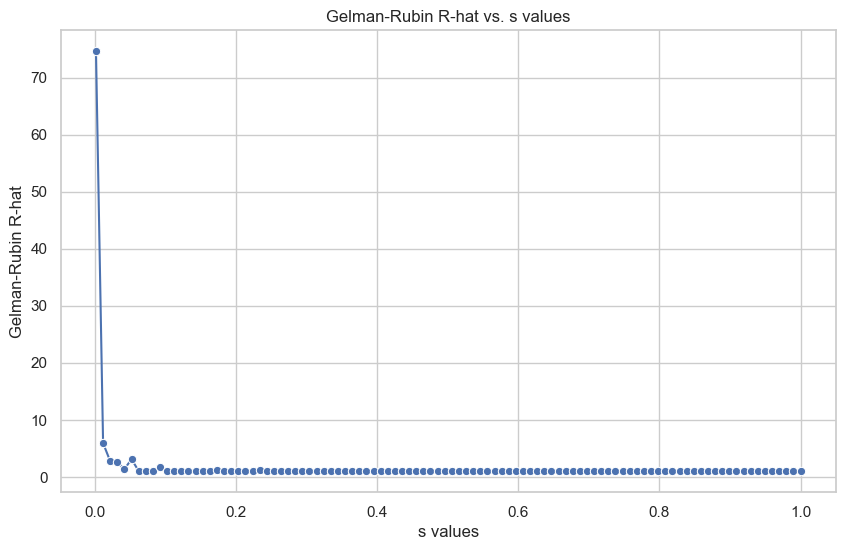

In [16]:
def gelman_rubin_rhat(N, J, target_dist, rng, s_values):
    rhat_values = []

    for s in s_values:
        chains = [metro_chain(N, target_dist, rng, s, initial_value=i) for i in range(J)]
        sample_means = [np.mean(chain) for chain in chains]
        between_sample_variance = np.sum((sample_means - np.mean(sample_means))**2) / J
        overall_within_variance = np.mean([np.var(chain) for chain in chains])
        rhat_value = np.sqrt((between_sample_variance + overall_within_variance) / overall_within_variance)
        rhat_values.append(rhat_value)

    return rhat_values

#parameters
N = 2000 
J = 4  
s_values = np.linspace(0.001, 1, 100)



rhat_values = gelman_rubin_rhat(N, J, target_dist, rng, s_values)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=s_values, y=rhat_values, marker='o')
plt.xlabel('s values')
plt.ylabel('Gelman-Rubin R-hat')
plt.title('Gelman-Rubin R-hat vs. s values')
plt.show()